# Image Classification with Google MobileNetV2

## Import Libraries

In [1]:
!pwd

/tf


In [2]:
!ls

tensorflow-tutorials


In [4]:
!echo $HOME

/root


In [3]:
!ls /

NGC-DL-CONTAINER-LICENSE    lib		 setup.cuda.sh
bin			    lib32	 setup.jupyter.sh
boot			    lib64	 setup.packages.sh
cuda-keyring_1.0-1_all.deb  libx32	 setup.python.sh
cuda-keyring_1.1-1_all.deb  media	 setup.sources.sh
dev			    mnt		 srv
etc			    opt		 sys
get-pip.py		    proc	 tf
gpu.packages.txt	    pythons.txt  tmp
gpu.requirements.txt	    root	 usr
home			    run		 var
jupyter.requirements.txt    sbin


In [8]:
ls /tf/tensorflow-tutorials/

README.md                   save_and_load.ipynb
classification.ipynb        text_classification.ipynb
overfit_and_underfit.ipynb  text_classification_with_hub.ipynb
regression.ipynb


In [9]:
ls /

NGC-DL-CONTAINER-LICENSE    lib@         setup.cuda.sh*
bin@                        lib32@       setup.jupyter.sh*
boot/                       lib64@       setup.packages.sh*
cuda-keyring_1.0-1_all.deb  libx32@      setup.python.sh*
cuda-keyring_1.1-1_all.deb  media/       setup.sources.sh*
dev/                        mnt/         srv/
etc/                        opt/         sys/
get-pip.py                  proc/        tf/
gpu.packages.txt            pythons.txt  tmp/
gpu.requirements.txt        root/        usr/
home/                       run/         var/
jupyter.requirements.txt    sbin@


In [19]:
!ls /home/hari/project

Colab		finetune-bloom-7b   huggingface   neo2.7b
LICENSE		finetune-llama2     langchain	  results
Utils-JypterNB	finetune-llama3-8b  mobilenet-v2  test.py


In [17]:
!ls /home/hari/

project


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
from sklearn.metrics import classification_report, accuracy_score
import warnings
warnings.filterwarnings("ignore")

2024-09-13 11:16:23.215084: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 11:16:23.215186: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 11:16:23.336062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Kinds of flowers
kinds = np.array(os.listdir('/kaggle/input/flowers-recognition/flowers'))
print(f"Flower kinds in this dataset: {kinds}")

Flower kinds in this dataset: ['dandelion' 'daisy' 'sunflower' 'tulip' 'rose']


In [3]:
# Paths of directories
path = '/kaggle/input/flowers-recognition/flowers'
kind_path = [path + "/" + flower for flower in kinds]
kind_path

['/kaggle/input/flowers-recognition/flowers/dandelion',
 '/kaggle/input/flowers-recognition/flowers/daisy',
 '/kaggle/input/flowers-recognition/flowers/sunflower',
 '/kaggle/input/flowers-recognition/flowers/tulip',
 '/kaggle/input/flowers-recognition/flowers/rose']

In [4]:
# Numbers of flowers for each kinds
for i, kind in enumerate(kind_path):
    print(f"There are {len(os.listdir(kind))} flowers in {kinds[i]}")

There are 1052 flowers in dandelion
There are 764 flowers in daisy
There are 733 flowers in sunflower
There are 984 flowers in tulip
There are 784 flowers in rose


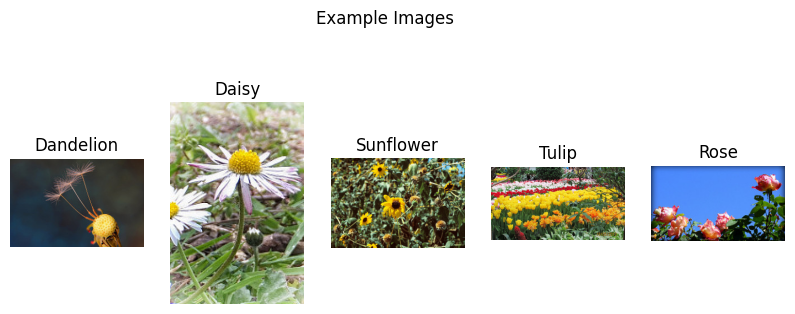

In [5]:
# Example images for each kinds
plt.figure(figsize=(10,4))
plt.suptitle("Example Images")
for i, kind in enumerate(kinds):
    ax = plt.subplot(1, 5, i+1)
    path = kind_path[i] + "/" + os.listdir(kind_path[i])[0]
    img = plt.imread(path)
    plt.imshow(img)
    plt.title(kind.capitalize())
    plt.axis("off")

In [6]:
# All ids
id_df = []
for i in range(len(kinds)):
    id = [img.split(".")[0] for img in os.listdir(kind_path[i])]
    id_df = id_df + id
len(id_df)

4317

In [7]:
# All kinds
kind_df = []
for i, kind in enumerate(kinds):
    for x in range(len(os.listdir(kind_path[i]))):
        kind_df.append(kind)
len(kind_df)

4317

In [8]:
# Create a dataframe
df = pd.DataFrame(columns=["id", "kind"])
df["id"] = id_df
df["kind"] = kind_df
df.tail()

,id,kind
4312,7820626638_3e2d712303,rose
4313,5148639829_781eb7d346,rose
4314,5335946401_f49bfbe3f9_n,rose
4315,8063462557_e0a8bd6c64_n,rose
4316,2536282942_b5ca27577e,rose


In [9]:
# Check numbers
df["kind"].value_counts()

kind
dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: count, dtype: int64

In [10]:
filenames = []
for i in range(len(kinds)):
    file = [kind_path[i] + "/" + kind for kind in os.listdir(kind_path[i])]
    filenames = filenames + file
filenames[:5]

['/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg']

In [11]:
# Check a random flower
print(filenames[2317])
print(df.loc[2317])

/kaggle/input/flowers-recognition/flowers/sunflower/8174935013_b16626b49b.jpg
id      8174935013_b16626b49b
kind                sunflower
Name: 2317, dtype: object


In [12]:
boolean_kinds = [kind == kinds for kind in kind_df]
boolean_kinds[:5]

[array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False])]

## Creating test and train sets

In [13]:
X = filenames
y = boolean_kinds

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=18)
len(X_train), len(X_test), len(y_train), len(y_test)

(3453, 864, 3453, 864)

In [15]:
X_train[:3], y_train[:3]

(['/kaggle/input/flowers-recognition/flowers/daisy/3598615130_578ed30e5f.jpg',
  '/kaggle/input/flowers-recognition/flowers/tulip/12949131454_4d3392f4dd_n.jpg',
  '/kaggle/input/flowers-recognition/flowers/tulip/7166554924_432aaae4b2_n.jpg'],
 [array([False,  True, False, False, False]),
  array([False, False, False,  True, False]),
  array([False, False, False,  True, False])])

## Preprocessing Images

In [16]:
image = imread(filenames[15])
image.shape

(240, 320, 3)

In [17]:
image.max(), image.min()

(255, 0)

In [18]:
image[:2]

array([[[ 8, 17, 46],
        [ 9, 18, 47],
        [10, 19, 48],
        ...,
        [29, 52, 70],
        [30, 53, 69],
        [31, 54, 70]],

       [[ 9, 18, 47],
        [ 9, 18, 47],
        [10, 19, 48],
        ...,
        [24, 47, 65],
        [26, 49, 65],
        [27, 50, 66]]], dtype=uint8)

In [19]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 320, 3), dtype=uint8, numpy=
array([[[ 8, 17, 46],
        [ 9, 18, 47],
        [10, 19, 48],
        ...,
        [29, 52, 70],
        [30, 53, 69],
        [31, 54, 70]],

       [[ 9, 18, 47],
        [ 9, 18, 47],
        [10, 19, 48],
        ...,
        [24, 47, 65],
        [26, 49, 65],
        [27, 50, 66]]], dtype=uint8)>

In [20]:
img_size = 224

In [21]:
# Create a function for preprocessing images
def process_image(image_path, img_size=img_size):
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])

  return image

In [22]:
process_image(X[17]), tf.constant(y[17])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.04313726, 0.03137255, 0.01176471],
         [0.04394656, 0.03218186, 0.01257402],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03137255, 0.02745098, 0.00784314],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04689806, 0.03513335, 0.01552551],
         [0.04728884, 0.03552413, 0.01591629],
         ...,
         [0.03400495, 0.03008338, 0.01047553],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04313726, 0.03137255, 0.01176471],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03504724, 0.03112567, 0.01151782],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        ...,
 
        [[0.436284  , 0.3447133 

## Creating data batches

In [23]:
# Create a simple function to return a tuple (image, label)
def get_image_label (image_path, label):
  image = process_image(image_path)
  return image, label

In [24]:
batch_size = 32

In [25]:
# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=batch_size, test_data=False):
    if test_data:
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    else:
        print("Creating data batches...")
        # Turn filepaths and labels into Tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                                   tf.constant(y)))
        # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
        data = data.shuffle(buffer_size=len(X))

        # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
        data = data.map(get_image_label)

        # Turn the training data into batches
        data_batch = data.batch(batch_size)
        return data_batch

In [26]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
test_data = create_data_batches(X_test, test_data=True)

Creating data batches...
Creating test data batches...


In [27]:
train_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)),
 TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))

In [28]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images[:2], train_labels[:2]

(array([[[[1.93277329e-01, 1.97198898e-01, 1.77591041e-01],
          [1.59662321e-01, 1.63583890e-01, 1.43976033e-01],
          [1.30446568e-01, 1.34368137e-01, 1.14760287e-01],
          ...,
          [2.42588371e-01, 2.57583261e-01, 2.13649407e-01],
          [2.54628420e-01, 2.62979358e-01, 2.25242868e-01],
          [2.55182087e-01, 2.59103656e-01, 2.28011221e-01]],
 
         [[1.21008411e-01, 1.24929979e-01, 1.05322137e-01],
          [1.38171837e-01, 1.42093405e-01, 1.22485556e-01],
          [1.44517496e-01, 1.48439065e-01, 1.28831223e-01],
          ...,
          [2.27208525e-01, 2.42088065e-01, 2.06672907e-01],
          [2.43772209e-01, 2.52123147e-01, 2.22607151e-01],
          [2.60224104e-01, 2.64145672e-01, 2.41036430e-01]],
 
         [[1.53221294e-01, 1.57142863e-01, 1.37535021e-01],
          [1.78294137e-01, 1.82215706e-01, 1.62607864e-01],
          [1.78238809e-01, 1.82160378e-01, 1.62552536e-01],
          ...,
          [2.02468008e-01, 2.15878159e-01, 1.8963

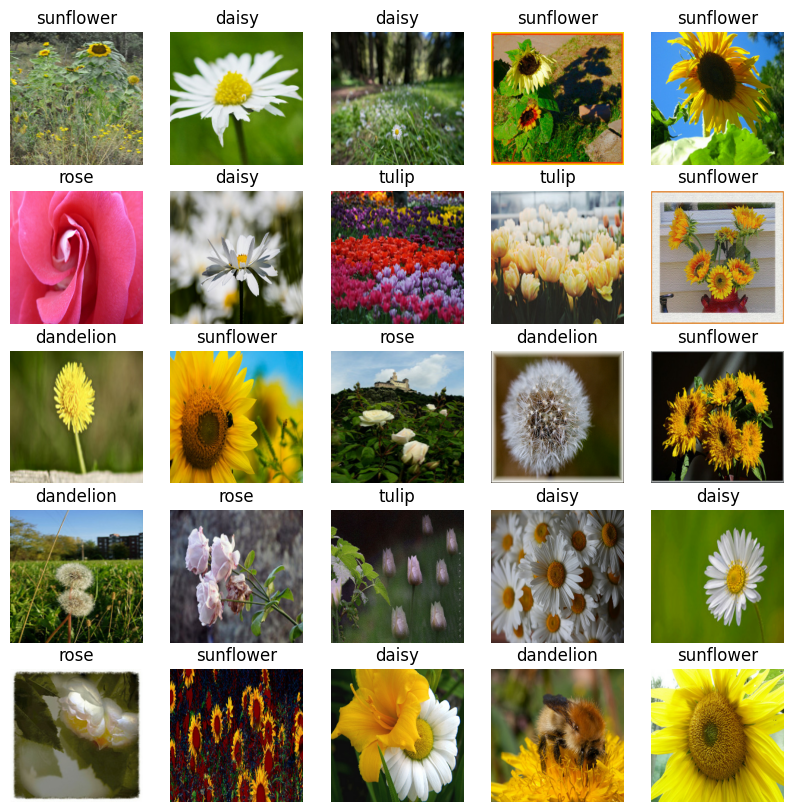

In [29]:
# Visualizing data batches
plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(train_images[i])
    plt.title(kinds[train_labels[i].argmax()])
    plt.axis("off")

## Model

In [30]:
# Setup input shape to the model
input_shape = [None, img_size, img_size, 3] # batch, height, width, colour channels

# Setup output shape of our model
output_shape = len(kinds)

In [31]:
model = tf.keras.Sequential([
    hub.KerasLayer("/kaggle/input/mobilenet-v2/tensorflow2/140-224-classification/2"), #input layer
    tf.keras.layers.Dense(units=output_shape,
                          activation="softmax") # output layer
])

In [32]:
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

In [33]:
!pip install kagglehub

In [34]:
import kagglehub 
kagglehub.model_download('google/mobilenet-v2/TensorFlow2/140-224-classification/2')

Attaching model 'google/mobilenet-v2/TensorFlow2/140-224-classification/2' to your Kaggle notebook...


'/kaggle/input/mobilenet-v2/tensorflow2/140-224-classification/2'

In [35]:
model.build(input_shape)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              6158505   
                                                                 
 dense (Dense)               (None, 5)                 5010      
                                                                 
Total params: 6163515 (23.51 MB)
Trainable params: 5010 (19.57 KB)
Non-trainable params: 6158505 (23.49 MB)
_________________________________________________________________


In [37]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=3)

In [38]:
  model.fit(x=train_data,
            epochs=150,
            callbacks=[early_stopping])

Epoch 1/150
  1/108 [..............................] - ETA: 11:33 - loss: 2.5620 - accuracy: 0.1250

I0000 00:00:1726226232.514657      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 [==============================] - 14s 70ms/step - loss: 0.6666 - accuracy: 0.7625
Epoch 2/150
108/108 [==============================] - 5s 47ms/step - loss: 0.3048 - accuracy: 0.8923
Epoch 3/150
108/108 [==============================] - 5s 47ms/step - loss: 0.2414 - accuracy: 0.9215
Epoch 4/150
108/108 [==============================] - 5s 47ms/step - loss: 0.2025 - accuracy: 0.9360
Epoch 5/150
108/108 [==============================] - 5s 47ms/step - loss: 0.1755 - accuracy: 0.9424
Epoch 6/150
108/108 [==============================] - 5s 47ms/step - loss: 0.1548 - accuracy: 0.9537
Epoch 7/150
108/108 [==============================] - 5s 47ms/step - loss: 0.1406 - accuracy: 0.9583
Epoch 8/150
108/108 [==============================] - 5s 48ms/step - loss: 0.1271 - accuracy: 0.9629
Epoch 9/150
108/108 [==============================] - 5s 47ms/step - loss: 0.1149 - accuracy: 0.9684
Epoch 10/150
108/108 [==============================] - 5s 48ms/step - loss: 0.1077 - accurac

## Predictions

In [39]:
type(test_data)

tensorflow.python.data.ops.batch_op._BatchDataset

In [40]:
predictions = model.predict(test_data)
predictions

27/27 [==============================] - 2s 65ms/step


array([[2.9127198e-04, 2.8541853e-04, 9.9942172e-01, 1.6108639e-06,
        1.8518010e-08],
       [6.6024368e-05, 6.4991191e-02, 9.3391192e-01, 7.1669753e-08,
        1.0306675e-03],
       [8.3075382e-04, 9.9916804e-01, 5.2197680e-07, 6.6496875e-07,
        3.6759378e-08],
       ...,
       [2.3369862e-10, 3.0844587e-09, 3.0233653e-06, 9.9896085e-01,
        1.0361962e-03],
       [3.1471116e-04, 2.2036500e-06, 2.7764994e-03, 9.9609548e-01,
        8.1113301e-04],
       [1.3220420e-02, 9.8176610e-01, 4.9548927e-03, 2.9420191e-05,
        2.9143035e-05]], dtype=float32)

In [41]:
true_labels = [kinds[np.argmax(data)] for data in y_test]
pred_labels = [kinds[np.argmax(pred)] for pred in predictions]

In [42]:
true_labels[:5]

['sunflower', 'sunflower', 'daisy', 'dandelion', 'tulip']

In [43]:
pred_labels[:5]

['sunflower', 'sunflower', 'daisy', 'dandelion', 'tulip']

In [44]:
print(accuracy_score(true_labels, pred_labels))

0.9097222222222222


## References

* https://github.com/mrdbourke/zero-to-mastery-ml/blob/master/section-4-unstructured-data-projects/end-to-end-dog-vision-video.ipynb